In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath('..'))

import cv2
import numpy as np
import geopandas as gpd
import pandas as pd
import networkx as nx
from shapely.geometry import Polygon as Poly, Point
from shapely.affinity import scale
import ogr
import time
from scipy.spatial import Voronoi, voronoi_plot_2d

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.cg import cg

from unittest.mock import Mock
from unittest.mock import MagicMock
from autocnet.graph import edge
from autocnet.graph import node
from autocnet.graph.node import Node
from plio.io import io_gdal

from autocnet.transformation.transformations import Homography
from autocnet.utils.utils import array_to_poly

from IPython.display import display

%pylab inline
figsize(20, 20)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def scale_point(point, centroid, scalar):
    point = np.asarray(point)
    centroid = centroid[:2]
    vector = ((point - centroid)*scalar) + centroid
    return (vector)

In [3]:
def reproj_point(H, point):
    """
    Reproject a pixel in one image into another image
    
    Parameters
    ----------
    H : object
        (3,3) ndarray or Homography object
        
    corner : iterable
             A 2 element iterable in the form x, y
    """
    if len(point) == 2:
        coords = np.array([point[0],point[1],1])
    elif len(point) == 3:
        coords = np.asarray(point)
        coords *= coords[-1]  # Homogenize
    
    return H.dot(coords)

In [28]:
def compute_intersection(source, graph, clean_keys=[]):
    source_corners = source.geodata.xy_corners
    source_poly = Poly(source_corners)
    
    source_gdf = gpd.GeoDataFrame({'source_geom': [source_poly], 'source_node': [source.node_id]}).set_geometry('source_geom')
    
    proj_list = []
    proj_nodes = []
    # Begin iterating through the nodes in the graph excluding the source node
    for n in graph.nodes_iter():
        if n == source.node_id:
            continue
        
        # Define the edge, matches, and destination based on the zero node and the nth node
        destination = graph.node[n]
        destination_corners = destination.geodata.xy_corners
        
        edge = graph.edge[source.node_id][destination.node_id]
        matches, _ = edge.clean(clean_keys=clean_keys)
        
        # Will still need the check but the helper function will make these calls much easier to understand
        if source.node_id > destination.node_id:
            kp2 = edge.get_keypoints('source', clean_keys = ['fundamental'], homogeneous = True)
            kp1 = edge.get_keypoints('destination', clean_keys = ['fundamental'], homogeneous = True)
        else:
            kp2 = edge.get_keypoints('destination', clean_keys = ['fundamental'], homogeneous = True)
            kp1 = edge.get_keypoints('source', clean_keys = ['fundamental'], homogeneous = True)

        # If the source image has coordinate transformation data
        if (source.geodata.coordinate_transformation.this != None) and (destination.geodata.coordinate_transformation.this != None):
            proj_poly = Poly(destination.geodata.xy_corners)
            
        # Else, use the homography transform to get an intersection of the two images
        else:
            H, mask = cv2.findHomography(kp2.values, kp1.values, cv2.RANSAC, 2.0)
            proj_corners = []
            for c in destination_corners:
                x, y, h = reproj_point(H, c)
                x /= h
                y /= h
                h /= h
                proj_corners.append((x, y))
                
            proj_poly = Poly(proj_corners)
        
        proj_list.append(proj_poly)
        proj_nodes.append(n)
    
    proj_gdf = gpd.GeoDataFrame({'proj_geom': proj_list, 'proj_node': proj_nodes}).set_geometry('proj_geom')
       
    intersect_gdf = gpd.overlay(source_gdf, proj_gdf, how='intersection')
    intersect_gdf = intersect_gdf.rename(columns = {'geometry':'intersect_geom'}).set_geometry('intersect_geom')
    intersect_gdf['overlaps_all'] = intersect_gdf.geometry.apply(lambda x:proj_gdf.geometry.contains(scale(x, .9, .9)).all())
    return intersect_gdf, proj_gdf, source_gdf

In [29]:
def vor(graph, source, clean_keys=[], verbose=False, s = 30):
    total_time = 0

    num_neighbors = len(graph.nodes()) - 1
    for n in graph.nodes():
        neighbors = len(graph.neighbors(n))
        if neighbors != num_neighbors:
            raise AssertionError('The graph is not complete')
    
    # Have compute_intersection get the intersections of the subgraph, the projected nodes in the
    # subgraph, and the source image all in there own geopandas dataframes
    intersect_gdf, proj_gdf, source_gdf = compute_intersection(source, graph, clean_keys)

    # Get the intersection for the given subgrpah
    intersection = intersect_gdf.query('overlaps_all == True')
    intersection_ind = intersect_gdf.query('overlaps_all == True').index.values[0]
    
    # Set the source, destination, edge, matches, and keypoints(kps) based on the first edge in the subgraph
    # which should be the smallest nodes in the graph
    for n in graph.nodes_iter():
        if n == source.node_id:
            continue
        destination = graph.node[n]
        edge = graph.edge[source.node_id][destination.node_id]
        matches, _ = edge.clean(clean_keys = clean_keys)
        kps = edge.get_keypoints(source, clean_keys = ['fundamental'], homogeneous = True)

        # Get all of the keypoints that are inside of the intersection then mask out the points
        # in kps that lie outside of the intersection
        kps['geometry'] = kps.apply(lambda x: Point(x['x'], x['y']), axis = 1)
        kps['point_in_intersect'] = kps['geometry'].apply(lambda x: intersection.geometry.contains(x).all())
        kps = kps[kps['point_in_intersect']]

        keypoints = []
        kps.apply(lambda x: keypoints.append((x['x'], x['y'])), axis = 1)
        coords = source_gdf.geometry.apply(lambda x:list(scale(x, s, s).exterior.coords))

        for array in coords:
            keypoints = np.vstack((keypoints, array))

        vor = Voronoi(keypoints)
        voronoi_df = pd.DataFrame(data = kps, columns = ['x', 'y', 'weight'])

        i = 0
        poly_array = []
        vor_points = np.asarray(vor.points)
        for region in vor.regions:
            region_point = vor_points[np.argwhere(vor.point_region==i)]
            if not -1 in region:
                polygon_points = [vor.vertices[i] for i in region]
                if len(polygon_points) != 0:
                    polygon = Poly(polygon_points)
                    poly_array.append(polygon)
                    poly_area = polygon.intersection(intersection.geometry[intersection_ind]).area
                    voronoi_df.loc[(voronoi_df["x"] == region_point[0][0][0]) & 
                                   (voronoi_df["y"] == region_point[0][0][1]), 
                                   'weight'] = poly_area
            i+=1

        poly_gdf = gpd.GeoDataFrame(data = poly_array, columns = ['geometry'])
        vor_poly_gdf = gpd.overlay(poly_gdf, intersection, how='intersection')
        edge.weight['vor_weight'] = voronoi_df['weight']
    
        if verbose:
            ax = proj_gdf.query('proj_node != ' + str(n)).plot(color='#388aff', alpha=0.1)
            proj_gdf.query('proj_node == ' + str(n)).plot(color = 'g', alpha=0.1, ax = ax)
            source_gdf.plot(color='r', alpha=0.1, ax=ax)
            vor_poly_gdf.plot(cmap='Set1', alpha=.5, ax=ax)
#             graph.edge[0][3].plot(clean_keys = ['fundamental'], ax = ax)
            source.plot(index_mask = edge.matches['destination_idx'], alpha = 0)
            matplotlib.pyplot.scatter(kps['x'], kps['y'], color = 'black', alpha = 1)
    return voronoi_df

In [6]:
#Point to the adjacency Graph
adjacency = get_path('vor_adjacency1.json')
basepath = get_path('Apollo15')
cang = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract f"eatures
cang.extract_features(method='sift', extractor_parameters={'nfeatures':1500})

#Match
cang.match_features()

#Apply outlier detection
# cg.apply_func_to_edges(Edge.symmetry_check)
cang.symmetry_checks()
# cg.apply_func_to_edges(Edge.ratio_check)
cang.ratio_checks()

#Compute a homography and apply RANSAC
cang.apply_func_to_edges("compute_fundamental_matrix", clean_keys=['ratio', 'symmetry'])

/home/acpaquette/autocnet/autocnet/transformation/transformations.py:356: UserWarning: Unable to apply MLE.  Not enough correspondences.
  warnings.warn("Unable to apply MLE.  Not enough correspondences.")


In [7]:
def compute_weights(cang, source_id, clean_keys = [], verbose = False):
    cliques = list(nx.cliques_containing_node(cang, nodes=source_id))
    source = cang.node[source_id]
    for g in cliques:
        subgraph = cang.create_node_subgraph(g)
        gdf_tup = vor(subgraph, source, clean_keys, verbose)

In [ ]:
cliques = list(nx.find_cliques(cang))
print(cliques)
start = time.clock()
compute_weights(cang, 5, clean_keys = ['fundamental'], verbose = True)
compute_weights(cang, 1, clean_keys = ['fundamental'], verbose = True)
print(time.clock() - start)

In [30]:
source_keypoint_df = pd.DataFrame({'x': (15, 18, 18, 12, 12), 'y': (6, 10, 15, 15, 10)})
destination_keypoint_df = pd.DataFrame({'x': (5, 8, 8, 2, 2), 'y': (1, 5, 10, 10, 5)})
keypoint_matches = [[0, 0, 1, 0],
                    [0, 1, 1, 1],
                    [0, 2, 1, 2],
                    [0, 3, 1, 3],
                    [0, 4, 1, 4]]

matches_df = pd.DataFrame(data = keypoint_matches, columns = ['source_image', 'source_idx', 
                                                                  'destination_image', 'destination_idx'])
# Source and Destination Node Setup
source_node = MagicMock(spec = Node())
destination_node = MagicMock(spec = Node())

source_node.get_keypoint_coordinates = MagicMock(return_value=source_keypoint_df)
destination_node.get_keypoint_coordinates = MagicMock(return_value=destination_keypoint_df)
source_node.node_id = 0
destination_node.node_id = 1

source_geodata = Mock(spec = io_gdal.GeoDataset)
destination_geodata = Mock(spec = io_gdal.GeoDataset)

source_node.geodata = source_geodata
destination_node.geodata = destination_geodata

source_node.geodata.coordinate_transformation.this = None
destination_node.geodata.coordinate_transformation.this = None

source_corners = [(0, 0),
                  (20, 0),
                  (20, 20),
                  (0, 20)]

destination_corners = [(0, 0),
                       (20, 0),
                       (20, 20),
                       (0, 20)]

source_node.geodata.xy_corners = source_corners
destination_node.geodata.xy_corners = destination_corners

# Edge Setup
e = edge.Edge(source = source_node, destination = destination_node)

e.clean = MagicMock(return_value=(matches_df, None))
e.matches = matches_df

def side_effect(node, clean_keys, **kwargs):
    if type(node) is str:
        node = node.lower()

    if isinstance(node, Node):
        node = node.node_id

    if node == "source" or node == "s" or node == source_node.node_id:
        return e.source.get_keypoint_coordinates().copy(deep=True)
    if node == "destination" or node == "d" or node == destination_node.node_id:
        return e.destination.get_keypoint_coordinates().copy(deep=True)
    
e.get_keypoints = MagicMock(side_effect = side_effect)

cang = MagicMock(spec = CandidateGraph())

cang.nodes = MagicMock(return_value=([0, 1]))
cang.node = [source_node, destination_node]
cang.nodes_iter = MagicMock(return_value=([0, 1]))
cang.neighbors = MagicMock(return_value = [1])
cang.edges = MagicMock(return_value=([(0, 1)]))
cang.edge = {0:{1:e}, 1:{0:e}}

,x,y,weight
0,5,1,22.50
1,8,5,26.25
2,8,10,37.50
3,2,10,37.50
4,2,5,26.25


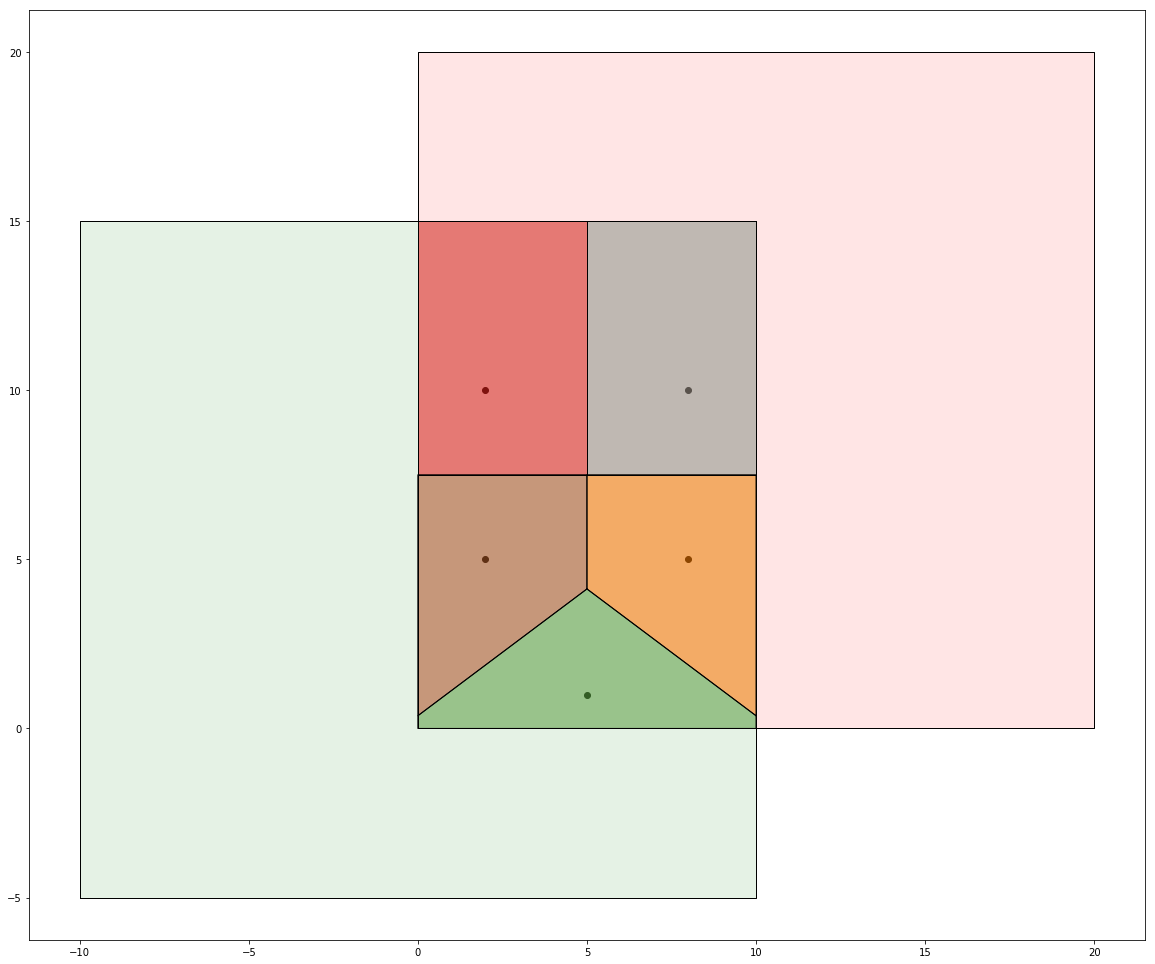

In [31]:
vor(cang, destination_node, clean_keys = [], verbose = True)

,x,y,weight
0,15,6,22.50
1,18,10,26.25
2,18,15,37.50
3,12,15,37.50
4,12,10,26.25


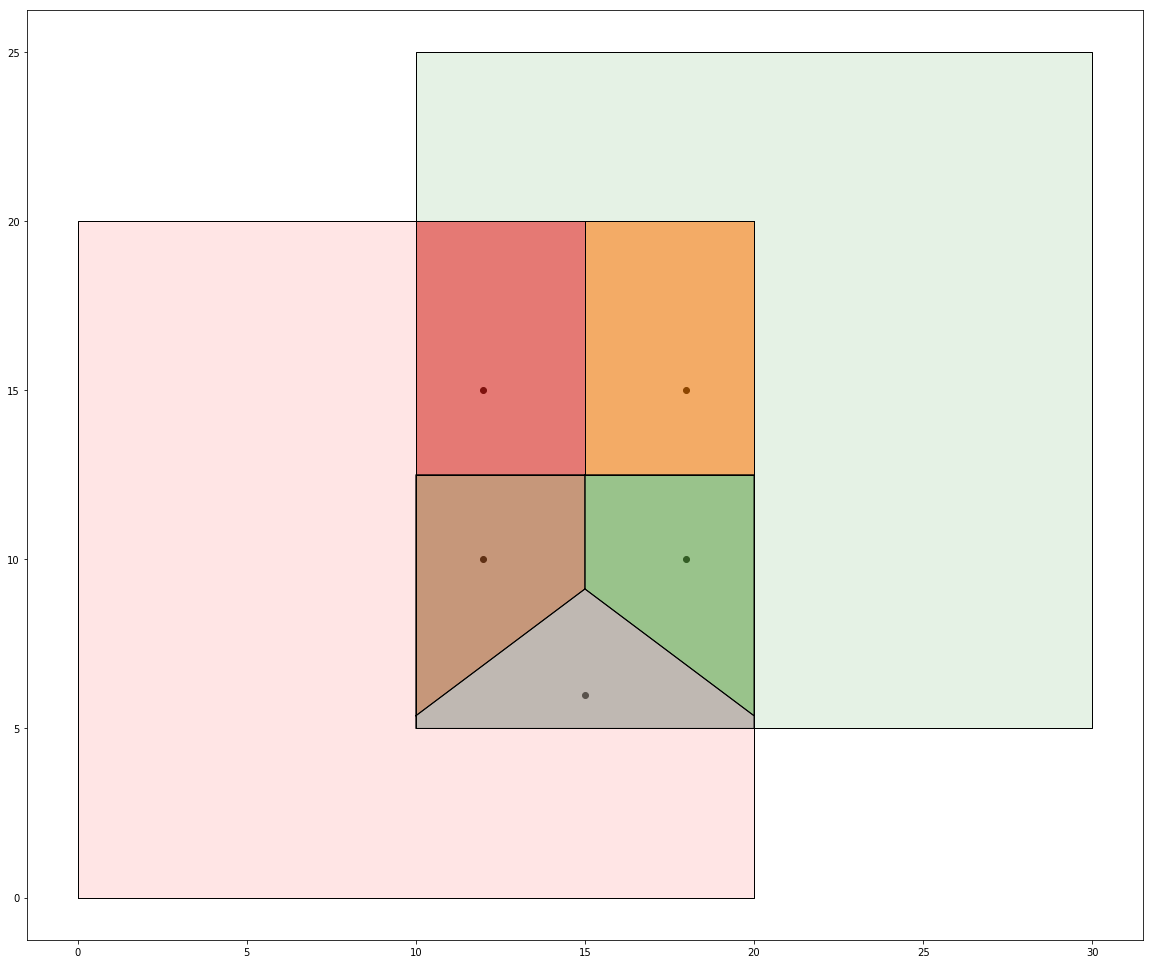

In [32]:
vor(cang, source_node, clean_keys = [], verbose = True)

In [33]:
# adjacency = get_path('two_image_adjacency.json')
# basepath = get_path('Apollo15')
# cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)
keypoint_df = pd.DataFrame({'x': (15, 18, 18, 12, 12), 'y': (6, 10, 15, 15, 10)})
keypoint_matches = [[0, 0, 1, 0],
                    [0, 1, 1, 1],
                    [0, 2, 1, 2],
                    [0, 3, 1, 3],
                    [0, 4, 1, 4]]

matches_df = pd.DataFrame(data = keypoint_matches, columns = ['source_image', 'source_idx', 
                                                                  'destination_image', 'destination_idx'])
e = edge.Edge(source = source_node, destination = destination_node)

e.clean = MagicMock(return_value=(matches_df, None))
e.matches = matches_df

source_node = MagicMock(spec = node.Node())
destination_node = MagicMock(spec = node.Node())

cang = MagicMock(spec = CandidateGraph())

cang.nodes = MagicMock(return_value=([0, 1]))
cang.node = [source_node, destination_node]
cang.nodes_iter = MagicMock(return_value=([0, 1]))
cang.neighbors = MagicMock(return_value=([0]))
cang.edges = MagicMock(return_value=([(0, 1)]))
cang.edge = {0:{1:e}, 1:{0:e}}

source_node.get_keypoint_coordinates = MagicMock(return_value=keypoint_df)
destination_node.get_keypoint_coordinates = MagicMock(return_value=keypoint_df)
source_node.node_id = 0
destination_node.node_id = 1

def side_effect(node, clean_keys, **kwargs):
    if type(node) is str:
        node = node.lower()

    if isinstance(node, Node):
        node = node.node_id

    if node == "source" or node == "s" or node == source_node.node_id:
        return e.source.get_keypoint_coordinates()
    if node == "destination" or node == "d" or node == destination_node.node_id:
        return e.destination.get_keypoint_coordinates()
    
e.get_keypoints = MagicMock(side_effect = side_effect)

e.source = source_node
e.destination = destination_node

source_geodata = Mock(spec = io_gdal.GeoDataset)
destination_geodata = Mock(spec = io_gdal.GeoDataset)

e.source.geodata = source_geodata
e.destination.geodata = destination_geodata

source_corners = [(0, 0),
                  (20, 0),
                  (20, 20),
                  (0, 20)]

destination_corners = [(10, 5),
                       (30, 5),
                       (30, 25),
                       (10, 25)]

source_xy_extent = [(0, 20), (0, 20)]

destination_xy_extent = [(10, 30), (5, 25)]

source_poly = array_to_poly(source_corners)
destination_poly = array_to_poly(destination_corners)

vals = {(10, 5):(10, 5), (20, 5):(20, 5), (20, 20):(20, 20), (10, 20):(10, 20)}

def latlon_to_pixel(i, j):
    return vals[(i, j)]

e.source.geodata.latlon_to_pixel = MagicMock(side_effect = latlon_to_pixel)
e.destination.geodata.latlon_to_pixel = MagicMock(side_effect = latlon_to_pixel)

e.source.geodata.footprint = source_poly
e.source.geodata.xy_corners = source_corners
e.source.geodata.xy_extent = source_xy_extent
e.destination.geodata.footprint = destination_poly
e.destination.geodata.xy_corners = destination_corners
e.destination.geodata.xy_extent = destination_xy_extent

,x,y,weight
0,15,6,22.50
1,18,10,26.25
2,18,15,37.50
3,12,15,37.50
4,12,10,26.25


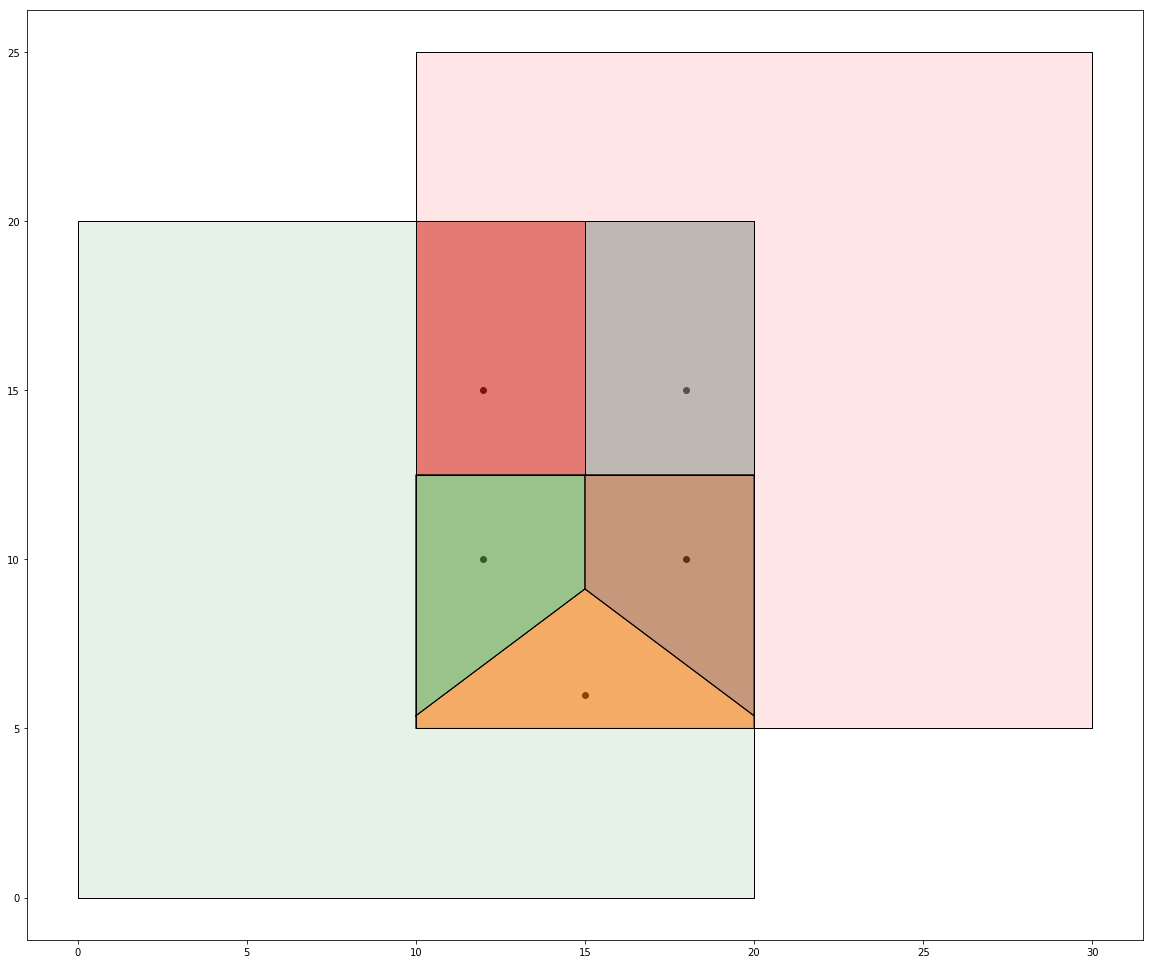

In [34]:
vor(cang, destination_node, clean_keys = [], verbose = True)

,x,y,weight
0,15,6,22.50
1,18,10,26.25
2,18,15,37.50
3,12,15,37.50
4,12,10,26.25


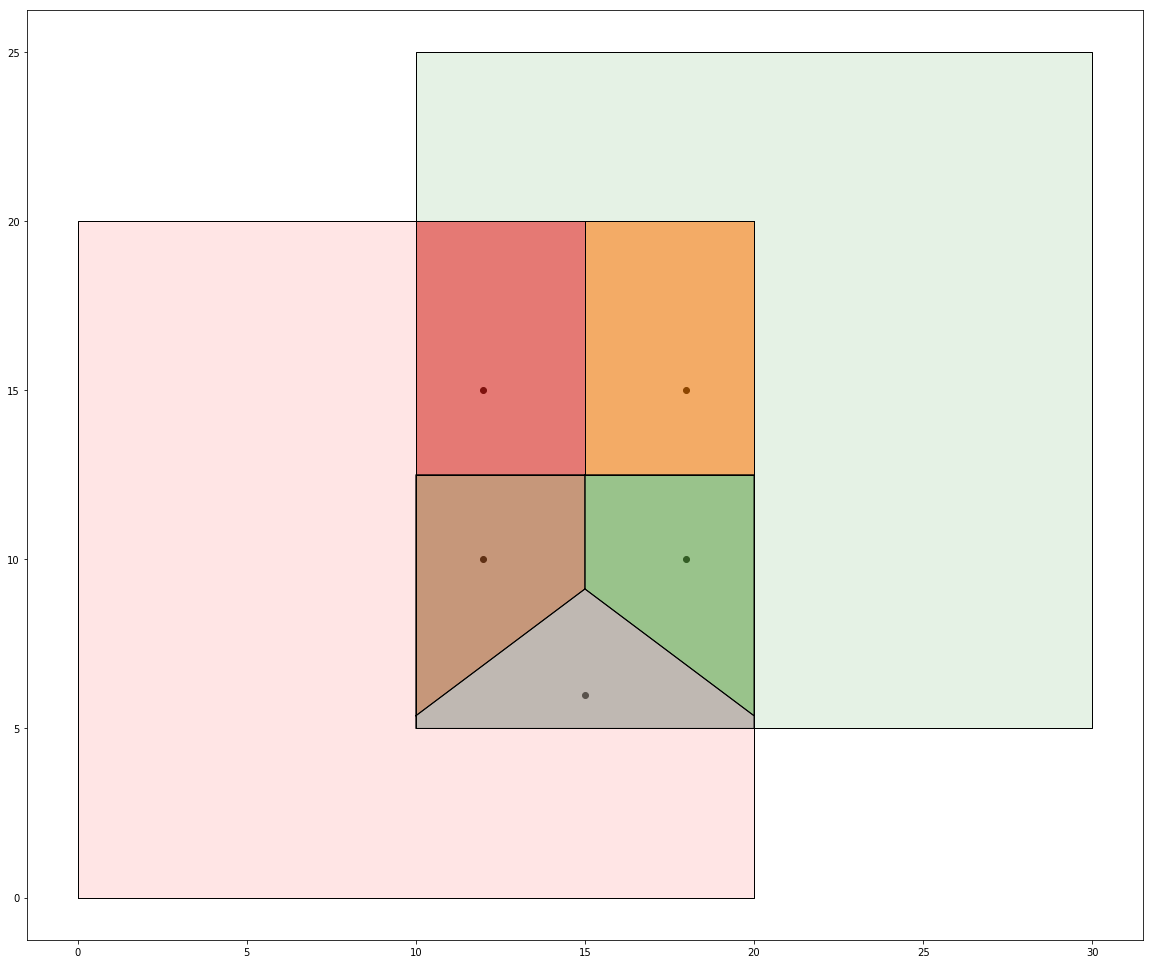

In [35]:
vor(cang, source_node, clean_keys = [], verbose = True)